### The purpose of this python notebook is to retrieve the hydraulic conductivity and retention capacity for the soils in the dataset using the staringreeks from Wageningen Environmental Research (WER).

Required inputs:
- Tabular dataset of soil sample points, with data for lutum fraction, soil organic carbon, and soil type classification for each point.
- Kriged raster map of groundwater depths in the area relative to sea level (NAP).
- A digital terrain model height map of the area. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.fill import fillnodata
from rasterio.plot import show

In [ ]:
# Fill nodata in the heightmap
heightmap_path = './Data/ahn_ribu.tif'

with rio.open(heightmap_path) as src:
    profile = src.profile
    arr = src.read(1)
    arr_filled = fillnodata(arr, mask=src.read_masks(1), max_search_distance=10, smoothing_iterations=0)

with rio.open('./Data/heightmap_filled.tif', 'w', **profile) as dest:
    dest.write_band(1, arr_filled)

In [2]:
# Load the datasets
# Make sure to fill nodata value in the heightmap.

topsoil_data = gpd.read_file('./Data/topsoil_samples.gpkg')
subsoil_data = gpd.read_file('./Data/subsoil_samples.gpkg')
groundwater_raster = rio.open('./Data/kriged_groundwater.tif')
staringreeks_df = pd.read_csv('./Data/staringreeks_2018.csv')
staringreeks_2_df = pd.read_csv('./Data/unit_properties_2018.csv')
heightmap = rio.open('./Data/heightmap_filled.tif')

In [3]:
staringreeks_df.head()


,year,unit,name,wcr,wcs,alpha,npar,lambda,ksfit
0,2018,1,B01,0.02,0.427,0.022,1.735,0.981,31.225
1,2018,2,B02,0.02,0.434,0.022,1.349,7.202,83.242
2,2018,3,B03,0.02,0.443,0.015,1.505,0.139,19.077
3,2018,4,B04,0.02,0.462,0.015,1.397,0.295,34.884
4,2018,5,B05,0.01,0.381,0.043,1.808,0.024,63.650


In [4]:
topsoil_data.head()

,datum,boorpunt_ID,BOVENKANT,ONDERKANT,analysemonster_ID,lutumgehalte,organisch_stofgehalte,leem,type,geometry
0,NaT,12088,0.1,0.5,8616,1.0,0.8,22.8,B03,POINT (121641 483535)
1,NaT,17290,0.0,0.5,12928,1.0,0.7,22.2,B03,POINT (122317 483576)
2,NaT,17291,0.0,0.5,12929,5.0,11.9,89.4,B05,POINT (122284 483579)
3,NaT,17357,0.0,0.5,12973,1.0,0.4,20.4,B03,POINT (121484 483339)
4,NaT,17365,0.0,0.2,12979,1.5,16.9,119.4,B15,POINT (122391.906 484589.127)


In [5]:
# For each point in the soil data, find the staringreeks entry that matches the soil type, then append the data to the soil data.
topsoil_data = topsoil_data.merge(
    staringreeks_df,
    left_on='type',
    right_on='name',
    how='left',
    suffixes=('', '_staringreeks')
)

In [6]:
# Then, find the groundwater depth for each point in the topsoil data.
# Note that the groundwater raster is relative to sea level, so we need to subtract the heightmap from the groundwater raster.
# We can do this using a spatial join operation.

def calc_groundwater_depth (row):
    """Calculate groundwater depth for a given row."""
    if row['geometry'] is not None:
        # Get the groundwater value at the point
        groundwater_value = list(groundwater_raster.sample([(row.geometry.x, row.geometry.y)]))[0][0]
        # Get the heightmap value at the point
        if list(heightmap.sample([(row.geometry.x, row.geometry.y)]))[0][0] < 3e+38:
            heightmap_value = list(heightmap.sample([(row.geometry.x, row.geometry.y)]))[0][0]
            h = (groundwater_value - heightmap_value) * 100 # Convert to cm 
            
            # Round h to the nearest of: 0, -10, -20, -31, -50, -100, -250, -500, -1000, -2500, -5000, -10000, -16000.
            if h >= 0:
                return 0
            elif -10 < h < 0:
                return -10
            elif -20 < h <= -10:
                return -20
            elif -31 < h <= -20:
                return -31
            elif -50 < h <= -31:
                return -50
            elif -100 < h <= -50:
                return -100
            elif -250 < h <= -100:
                return -250
            elif -500 < h <= -250:
                return -500
            elif h <= -500:
                return -1000
            
        else:
            return None
    else:
        return None

topsoil_data['groundwater_depth'] = topsoil_data.apply(calc_groundwater_depth, axis=1)

In [7]:
topsoil_data.head()

,datum,boorpunt_ID,BOVENKANT,ONDERKANT,analysemonster_ID,lutumgehalte,organisch_stofgehalte,leem,type,geometry,year,unit,name,wcr,wcs,alpha,npar,lambda,ksfit,groundwater_depth
0,NaT,12088,0.1,0.5,8616,1.0,0.8,22.8,B03,POINT (121641 483535),2018.0,3.0,B03,0.02,0.443,0.015,1.505,0.139,19.077,-250.0
1,NaT,17290,0.0,0.5,12928,1.0,0.7,22.2,B03,POINT (122317 483576),2018.0,3.0,B03,0.02,0.443,0.015,1.505,0.139,19.077,-100.0
2,NaT,17291,0.0,0.5,12929,5.0,11.9,89.4,B05,POINT (122284 483579),2018.0,5.0,B05,0.01,0.381,0.043,1.808,0.024,63.650,-10.0
3,NaT,17357,0.0,0.5,12973,1.0,0.4,20.4,B03,POINT (121484 483339),2018.0,3.0,B03,0.02,0.443,0.015,1.505,0.139,19.077,-250.0
4,NaT,17365,0.0,0.2,12979,1.5,16.9,119.4,B15,POINT (122391.906 484589.127),2018.0,15.0,B15,0.01,0.528,0.024,1.282,-1.478,87.451,-100.0


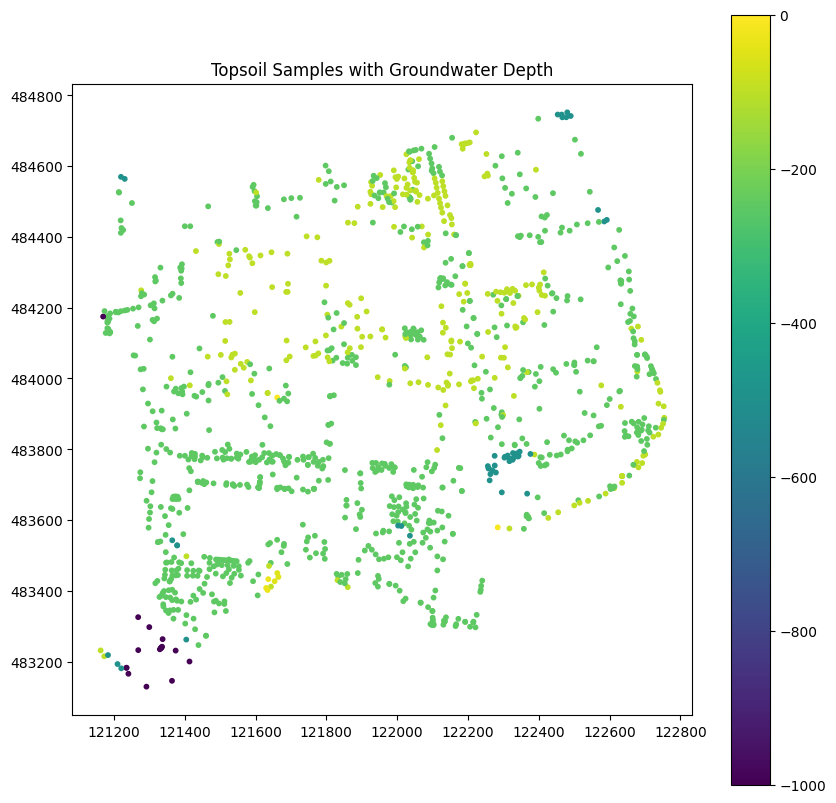

In [8]:
# Now we can plot the topsoil data with the groundwater depth.
fig, ax = plt.subplots(figsize=(10, 10))
topsoil_data.plot(column='groundwater_depth', ax=ax, legend=True, cmap='viridis', markersize=10)
ax.set_title('Topsoil Samples with Groundwater Depth')
plt.show()

In [9]:
staringreeks_2_df.head()

,unit,var,0,-10,-20,-31,-50,-100,-250,-500,-1000,-2500,-5000,-10000,-16000
0,1,k,31.230,14.210,7.310,3.640,1.230,0.1430,0.004290,0.000251,1.410000e-05,3.040000e-07,1.670000e-08,9.150000e-10,1.280000e-10
1,1,wc,0.427,0.416,0.393,0.363,0.315,0.2290,0.135000,0.090000,6.200000e-02,4.200000e-02,3.300000e-02,2.800000e-02,2.555000e-02
2,1,z1,0.000,9.900,19.900,30.600,48.700,87.7000,118.600000,121.600000,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02
3,1,z2,0.000,9.900,19.700,30.300,47.600,80.0000,98.600000,100.100000,1.003000e+02,1.003000e+02,1.003000e+02,1.003000e+02,1.003000e+02
4,2,k,83.240,12.400,4.610,1.830,0.483,0.0385,0.000621,0.000020,5.860000e-07,5.130000e-09,1.400000e-10,3.790000e-12,3.280000e-13


In [10]:
def get_wc(soil_unit, gw_height):
    wc_values = staringreeks_2_df[soil_unit]['wc']
    if gw_height in wc_values:
        return wc_values[gw_height]
    else:
        return None

In [20]:
def get_wc(unit, gw_height):
    try:
        unit_int = int(unit)
        gw_col = str(int(gw_height)) if float(gw_height).is_integer() else str(gw_height)
        row = staringreeks_2_df[(staringreeks_2_df['unit'] == unit_int) & (staringreeks_2_df['var'] == 'wc')]
        if not row.empty and gw_col in row.columns:
            return row.iloc[0][gw_col]
        else:
            return None
    except Exception:
        return None

def get_k(unit, gw_height):
    try:
        unit_int = int(unit)
        gw_col = str(int(gw_height)) if float(gw_height).is_integer() else str(gw_height)
        row = staringreeks_2_df[(staringreeks_2_df['unit'] == unit_int) & (staringreeks_2_df['var'] == 'k')]
        if not row.empty and gw_col in row.columns:
            return row.iloc[0][gw_col]
        else:
            return None
    except Exception:
        return None
    
def get_z1(unit, gw_height):
	try:
		unit_int = int(unit)
		gw_col = str(int(gw_height)) if float(gw_height).is_integer() else str(gw_height)
		row = staringreeks_2_df[(staringreeks_2_df['unit'] == unit_int) & (staringreeks_2_df['var'] == 'z1')]
		if not row.empty and gw_col in row.columns:
			return row.iloc[0][gw_col]
		else:
			return None
	except Exception:
		return None

def get_z2(unit, gw_height):
	try:
		unit_int = int(unit)
		gw_col = str(int(gw_height)) if float(gw_height).is_integer() else str(gw_height)
		row = staringreeks_2_df[(staringreeks_2_df['unit'] == unit_int) & (staringreeks_2_df['var'] == 'z2')]
		if not row.empty and gw_col in row.columns:
			return row.iloc[0][gw_col]
		else:
			return None
	except Exception:
		return None

topsoil_data['wc'] = topsoil_data.apply(lambda row: get_wc(row['unit'], row['groundwater_depth']), axis=1)
topsoil_data['k'] = topsoil_data.apply(lambda row: get_k(row['unit'], row['groundwater_depth']), axis=1)
topsoil_data['z1'] = topsoil_data.apply(lambda row: get_z1(row['unit'], row['groundwater_depth']), axis=1)
topsoil_data['z2'] = topsoil_data.apply(lambda row: get_z2(row['unit'], row['groundwater_depth']), axis=1)